In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
!nvidia-smi

Fri Mar 18 18:54:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    62W / 149W |    175MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import dataset from google drive
# please change to your directory of the dataset to run the code

train_dir = ('/content/drive/MyDrive/imageset/train')
validation_dir = ('/content/drive/MyDrive/imageset/val')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


Maunally change the foder name to the represent numbers,
* church 1
* chainsaw 2
* dog 3
* fish 4
* french horn 5
* golf ball 6
* parachute 7
* petrol station 8
* radio 9
* truck 10




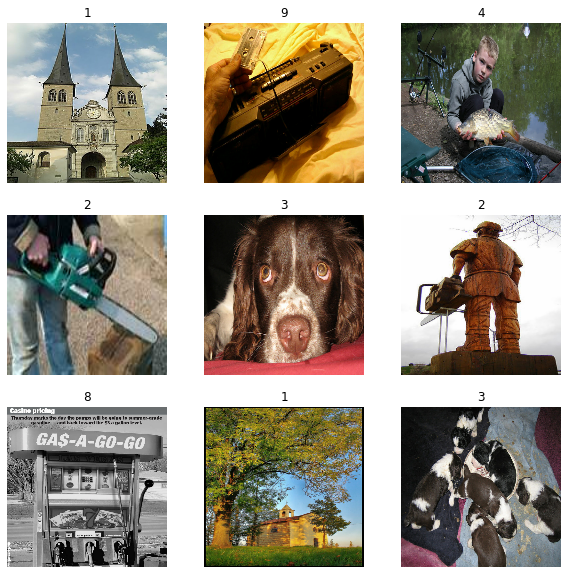

In [ ]:
# print out the photo to check what data we have

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [ ]:
# As the original dataset doesn't contain a test set, you will create one. 
# To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, 
# then move 20% of them to a test set.

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 99
Number of test batches: 24


In [ ]:
# Configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking. 

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data augmentation
# artificially introduce sample diversity by applying random, yet realistic,
# transformations to the training images, such as rotation and horizontal flipping. 
# This helps expose the model to different aspects of the training data and reduce overfitting. 

# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [ ]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [ ]:
# Rescale pixel values from [0, 255] to [-1, 1] to fit MobileNetV2 expected pixel values.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Note: Alternatively, could also use rescale pixel values from [0, 255] to [-1, 1] using tf.keras.layers.Rescaling.
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. 
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 160, 160, 3)
(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
# Add a classification head
# To generate predictions from the block of features, average over the spatial 5x5 spatial locations, 
# using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
# Add one dense layer
d1_layer = tf.keras.layers.Dense(64, activation='relu')
d1_batch = d1_layer(feature_batch_average)
print(d1_batch.shape)

(32, 64)


In [ ]:
# set prediction layer
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
prediction_batch = prediction_layer(d1_batch)
print(prediction_batch.shape)

(32, 10)


In [ ]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.

inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = d1_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

4

In [ ]:
# train the model
initial_epochs = 3

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/3
120/296 [===========>..................] - ETA: 10:03 - loss: 1.6293 - accuracy: 0.4982

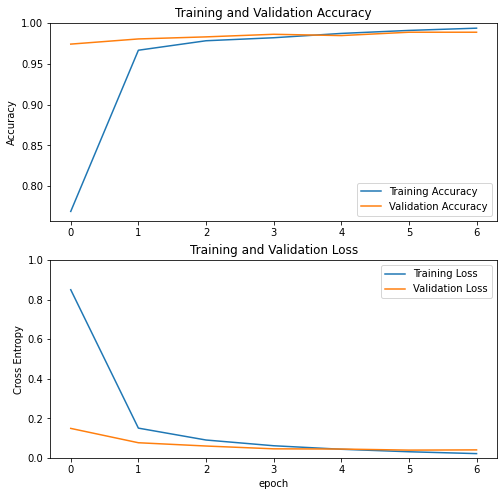

In [ ]:
# plot ROC curve

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('acc_loss_1.png')
plt.show()

In [ ]:
# save model

import pickle

# save model
#pkl_filename = "/content/drive/MyDrive/Applied Machine Learning Lab/CW2_moblienet_v2.pkl"
pkl_filename = "CW2_moblienet_v2.pkl"

# with open(pkl_filename, "wb") as file:
#   pickle.dump(model, file)

 # load model
with open(pkl_filename, "rb") as file:
   model_checkpoint = pickle.load(file) 

model_checkpoint

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: ignored

In [ ]:
# Unfreeze the base_model and set the bottom layers to be un-trainable. 
# Then, recompile the model (necessary for these changes to take effect), and resume training.
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# recompile model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
len(model.trainable_variables)

In [ ]:
# Continue training the model
# If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 3/6
296/296 [==============================] - 64s 193ms/step - loss: 0.0610 - accuracy: 0.9818 - val_loss: 0.0454 - val_accuracy: 0.9861
Epoch 4/6
296/296 [==============================] - 56s 186ms/step - loss: 0.0432 - accuracy: 0.9871 - val_loss: 0.0443 - val_accuracy: 0.9845
Epoch 5/6
296/296 [==============================] - 58s 192ms/step - loss: 0.0306 - accuracy: 0.9908 - val_loss: 0.0389 - val_accuracy: 0.9886
Epoch 6/6
296/296 [==============================] - 58s 193ms/step - loss: 0.0212 - accuracy: 0.9936 - val_loss: 0.0400 - val_accuracy: 0.9886


In [ ]:
# caculate the accuracy and loss after fine tuning 

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

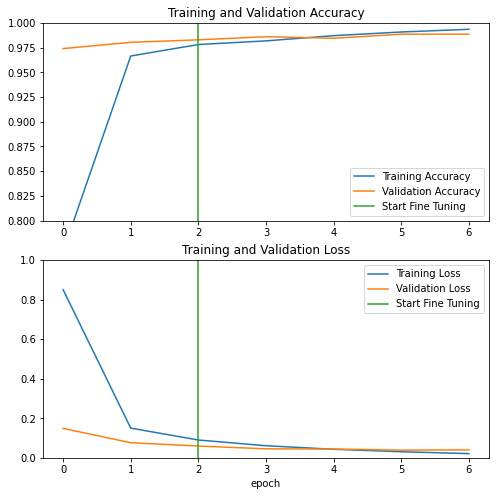

In [ ]:
# visualise result

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('acc_loss2.png')
plt.show()

### Evaluation and prediction
Finaly you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

24/24 [==============================] - 4s 133ms/step - loss: 0.0639 - accuracy: 0.9818
Test accuracy : 0.9817708134651184


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

array([1.77509918e-07, 3.72283866e-05, 1.69940559e-08, 1.54049906e-06,
       1.11489715e-06, 1.32796970e-07, 1.76701562e-07, 9.99959588e-01,
       1.23854065e-07, 2.23832171e-08, 5.57045787e-08, 1.84991281e-04,
       8.59447573e-06, 3.62457431e-05, 1.11812305e-05, 2.93435448e-07,
       1.42315012e-05, 1.28852353e-05, 9.58056092e-01, 4.16753925e-02,
       4.57389127e-10, 5.25384166e-07, 1.32512162e-06, 2.11723048e-07,
       1.62137496e-07, 3.59374326e-08, 4.20811830e-07, 2.64655076e-09,
       1.06206210e-03, 9.98935163e-01, 2.50254357e-06, 7.84597489e-07,
       7.57653288e-06, 2.44904896e-07, 4.47429011e-05, 9.99931335e-01,
       8.42412760e-07, 1.01590740e-06, 8.38557298e-07, 1.01431633e-05,
       9.99151349e-01, 3.66569548e-05, 8.74813395e-07, 4.51929782e-06,
       2.88055653e-05, 8.75529986e-06, 6.35954279e-07, 7.65610952e-04,
       1.68200529e-06, 1.09152779e-06, 5.41537393e-09, 4.28615112e-06,
       1.61373991e-05, 1.47618521e-05, 1.68957661e-06, 6.67839515e-07,
      

### Attemption of self defined CNN network
### Due to time limitation the content is not well stuctureed or optimised yet

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

# # import dataset from google drive
# # please change to your directory of the dataset to run the code

# train_dir = ('/content/drive/MyDrive/imageset/train')
# validation_dir = ('/content/drive/MyDrive/imageset/val')

# BATCH_SIZE = 32
# IMG_SIZE = (160, 160)

# train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                             shuffle=True,
#                                                             batch_size=BATCH_SIZE,
#                                                             image_size=IMG_SIZE)

# validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE)

In [ ]:
# # attemption to rename filename but failed
# # Pythono3 code to rename multiple
# # files in a directory or folder
 
# # importing os module
# import os
 
# # Function to rename multiple files
# def main():
   
#     folder = "/content/drive/MyDrive/imageset/val"
#     for count, filename in enumerate(os.listdir(folder)):
#         dst = f"Hostel {str(count)}.jpg"
#         src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
#         dst =f"{folder}/{dst}"
         
#         # rename() function will
#         # rename all the files
#         os.rename(src, dst)
 
# # Driver Code
# if __name__ == '__main__':
     
#     # Calling main() function
#     main()

In [ ]:
# # print out the photo to check what data we have

# class_names = train_dataset.class_names


# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")
#     plt.savefig('images.png')

In [ ]:
# # 1st version of stucture

# class MyModel(Model):
#  def __init__(self):
#  super(MyModel, self).__init__()
#  #define a convolutional layer, 32 - kernel numbers 3 - kernel size
#  self.conv1 = Conv2D(32, 3, activation='relu')
#  #define max pooling layer
#  self.pool1 = MaxPool2D()
#  #define function to convert from 2D image (response maps) to 1D vector
#  self.flatten = Flatten()
#  #define fully connected layer, output size 128
#  self.d1 = Dense(128, activation='relu')
#  #define fully connected layer, output size 10
#  self.d2 = Dense(10)
#  def call(self, x):
#  #use of the defined covolutional layer
#  x = self.conv1(x)
#  #use of the defined pooling layer
#  x = self.pool1(x)
#  #use of the flatten function
#  x = self.flatten(x)
#  #use of the fully connected layer 1
#  x = self.d1(x)
#  #use of the fully connected layer 2
#  return self.d2(x)
# # Create an instance of the model
# model = MyModel()
# #define loss function
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# #define optimizer
# optimizer = tf.keras.optimizers.Adam()
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
# print(train_accuracy)


In [ ]:
# # 2nd version of model, trying to increase lyers to improve accuracy

# from tensorflow.keras import Model

# class MyModel(Model):
#  def __init__(self):
#   super(MyModel, self).__init__()
#   #define a convolutional layer, 32 - kernel numbers 3 - kernel size
#   self.conv1 = Conv2D(32, 3, activation='relu')
#   #define a convolutional layer, 64 - kernel numbers 3 - kernel size
#   self.conv2 = Conv2D(64, 3, activation='relu')
#   #define max pooling layer
#   self.pool1 = MaxPool2D()
#   #define a convolutional layer, 64 - kernel numbers 3 - kernel size
#   self.conv3 = Conv2D(64, 3, activation='relu')
#   #define a convolutional layer, 32 - kernel numbers 3 - kernel size
#   self.conv4 = Conv2D(32, 3, activation='relu')
#   #define a convolutional layer, 32 - kernel numbers 3 - kernel size
#   self.conv5 = Conv2D(32, 3, activation='relu')
#   #define function to convert from 2D image (response maps) to 1D vector
#   self.flatten = Flatten()
#   #define fully connected layer, output size 128
#   self.d1 = Dense(128, activation='relu')
#   #define fully connected layer, output size 64
#   self.d2 = Dense(64, activation='relu')
#   #define fully connected layer, output size 10
#   self.d3 = Dense(1, activation='softmax')
#  def call(self, x):
#   #use of the defined covolutional layer
#   x = self.conv1(x)
#   #use of the defined covolutional layer
#   x = self.conv2(x)
#   #use of the defined pooling layer
#   x = self.pool1(x)
#   #use of the defined covolutional layer
#   x = self.conv3(x)
#   #use of the defined covolutional layer
#   x = self.conv4(x)
#   #use of the defined covolutional layer
#   x = self.conv5(x)
#   #use of the flatten function
#   x = self.flatten(x)
#   #use of the fully connected layer 1
#   x = self.d1(x)
#   #use of the fully connected layer 2
#   x = self.d2(x)
#   #use of the fully connected layer 3
#   return self.d3(x)

# # Create an instance of the model
# model = MyModel()
# #define loss function
# loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# #define optimizer
# optimizer = tf.keras.optimizers.Adam()
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
# print(train_accuracy)

In [ ]:
# # Here is the part to define training function, every time it takes images and labels as input, use the CNN model to 
# # provide the prediction calculate the losses,and calculate the gradients. The optimizer will use learning rate to 
# # multiply the gradient to update all the trainable vairables

# @tf.function
# def train_step(images, labels):
#  with tf.GradientTape() as tape:
#  # training=True is only needed if there are layers with different
#  # behavior during training versus inference (e.g. Dropout).
#   predictions = model(images, training=True)
#   loss = loss_object(labels, predictions)
#   gradients = tape.gradient(loss, model.trainable_variables)
#   optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#   train_loss(loss)
#   train_accuracy(labels, predictions)

# #Here is the function to evaluate the accuracy of the testing images
# @tf.function
# def test_step(images, labels):
#  # training=False is only needed if there are layers with different
#  # behavior during training versus inference (e.g. Dropout).
#  predictions = model(images, training=False)
#  t_loss = loss_object(labels, predictions)
#  test_loss(t_loss)
#  test_accuracy(labels, predictions)

# # Here is the main part of the training of CNN model, assume we will go 5 epochs and each epoch will use all the 
# # training data for reducing the losses
# EPOCHS = 5
# for epoch in range(EPOCHS):
#  # Reset the metrics at the start of the next epoch
#  train_loss.reset_states()
#  train_accuracy.reset_states()
#  test_loss.reset_states()
#  test_accuracy.reset_states()
#  for images, labels in train_dataset:
#   train_step(images, labels)
#  for test_images, test_labels in validation_dataset:
#   test_step(test_images, test_labels)
#  print(
#  f'Epoch {epoch + 1}, '
#  f'Loss: {train_loss.result()}, '
#  f'Accuracy: {train_accuracy.result() * 100}, '
#  f'Test Loss: {test_loss.result()}, '
#  f'Test Accuracy: {test_accuracy.result() * 100}'
#  )

In [ ]:
# # save model

# import pickle

# # save model
# pkl_filename = "/content/drive/MyDrive/Applied Machine Learning Lab/CW2_my_model_v2.pkl"
# with open(pkl_filename, "wb") as file:
#   pickle.dump(model, file)

#  # load model
# with open(pkl_filename, "rb") as file:
#    model_checkpoint = pickle.load(file) 

# #model_checkpoint

# New Section